# Generative Adversarial Networks

Применение adversarial loss (более общей идеи, лежащей в основе GANов) позволило решить задачи, которые казались невозможными:

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

* [Машинный перевод без параллельных данных](https://arxiv.org/pdf/1710.11041.pdf)
* [Циклоганы: перевод изображений в другой домен](https://arxiv.org/abs/1703.10593)
* Колоризация и [Super Resolution](https://arxiv.org/abs/1807.02758)
* [Генерация и морфинг произвольных данных](https://arxiv.org/pdf/1809.11096.pdf) ([тут](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/biggan_generation_with_tf_hub.ipynb#scrollTo=HuCO9tv3IKT2) можно поиграться с генерацией бургеров)
* Применения в борьбе с adversarial атаками

Вот постоянно пополняющийся список приложений GANов: https://github.com/nashory/gans-awesome-applications

Сама [статья](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) Яна Гудфеллоу про GANы вышла в конце 2014 года и была процитирована 7687 раз за 4 года.


<img width='500px' src='https://cdn-images-1.medium.com/max/800/1*eWURQXT41pwHvDg1xDiEmw.png'>

Теперь немного формальных определений:

* Пусть $z$ — это вектор из латентного пространства, насэмпленный из нормального распределения.
* $G(z)$ обозначает функцию генератора, которая отображает латентный вектор в пространство данных. Цель $G$ — оценить истинное распределение данных $p_d$, чтобы сэмплировать данные из оцененного распределения $p_g$.
* $D(G(z))$ это вероятность (число от 0 до 1), что выход генератора $G$ является реальным изображением.

$D$ и $G$ играют в минимаксную игру, в которой $D$ старается максимизировать вероятность, что он правильно классифицирует реальные и сгенерированные сэмплы, а $G$ старается минимизировать эту вероятность:

$$\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(x)))\big]$$

[Выясняется](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), что решение в этой минимаксной игре достигается при $p_g = p_d$ (и дискриминатор в этом случае может угадывать случайно). В реальности модели не всегда могут сойтись к этой точке.

[DCGAN](https://arxiv.org/pdf/1511.06434.pdf) (Deep Convolutional GAN) называют GAN, который явно использует свёртки и транспонированные свёртки в дискриминаторе и генераторе соответственно. Откройте статью -- мы будем идти очень близко с авторами.

## Датасет
Всем надоели цифры, поэтому обучаться мы будем на датасете CelebA ([Large-scale CelebFaces Attributes](Large-scale CelebFaces Attributes)). В датасете на каждую фотку есть её аттрибуты, но мы их пока использовать не будем.

<img width='500px' src='http://mmlab.ie.cuhk.edu.hk/projects/celeba/overview.png'>

Автор, когда готовил эту тетрадку, долго думал, как загрузить датасет, чтобы всем было удобно. Это оказалось трудно, потому что прямых ссылок на него нигде нет, и, соответственно, просто сделать `!wget ...` нельзя. По удачному стечению обстоятельств, неделю назад кто-то [добавил](https://github.com/pytorch/vision/blob/master/torchvision/datasets/celeba.py) скрипты для загрузки этого датасета в сам `torchvision`, но в `pip` новая версия за такой срок ещё не успела появиться, поэтому мы обновимся напрямую из репозитория на гитхабе:

In [1]:
# модель будет обучаться долго - рекомендую сохранять промежуточные версии. В колабе это можно делать примерно так
from google.colab import drive
drive.mount('/content/drive')
#теперь для сохранения файлов вам доступна директория /content/drive

Mounted at /content/drive


In [2]:
!pip install git+https://github.com/pytorch/vision.git

  Cloning https://github.com/pytorch/vision.git to /tmp/pip-req-build-81ylwijg
  Running command git clone -q https://github.com/pytorch/vision.git /tmp/pip-req-build-81ylwijg
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  ERROR: Failed building wheel for torchvision
Failed to build torchvision
ERROR: Could not build wheels for torchvision which use PEP 517 and cannot be installed directly


In [3]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets

In [14]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [22]:
device = torch.device('cuda:0')  # не забудьте включить GPU

image_size = 64
batch_size = 64

In [23]:
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # Normalize здесь приводит значения в промежуток [-1, 1]
])

In [24]:
# Root directory for dataset
dataroot = "data/celeba"

In [ ]:
#dataset = datasets.CelebA('data', download=True, transform=transform)

In [38]:
!unzip /content/data/celeba/img_align_celeba

Archive:  /content/data/celeba/img_align_celeba.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/data/celeba/img_align_celeba or
        /content/data/celeba/img_align_celeba.zip, and cannot find /content/data/celeba/img_align_celeba.ZIP, period.


In [25]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transform)
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

FileNotFoundError: ignored

In [11]:


dataset = datasets.CelebA('data', download=True, transform=transform)

# dataset = datasets.ImageFolder(root='/content/data/celeba/',
#                               transform=transform)

loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

BadZipFile: ignored

In [ ]:
dataset[5][0]

In [ ]:
def show_img(sample):
  img = sample[1]
  img = img / 2 + 0.5
  npimg = img.numpy()
  npimg = np.clip(npimg, 0., 1.)
  npimg_color = np.transpose(npimg, (1, 2, 0))
  X = sample[0]
  _, H, W = X.shape
  img = np.zeros((H, W, 3))
  img[:,:,1] = img[:,:,2] = img[:,:,0] = X
  f = plt.figure(figsize=(20, 20))
  f.add_subplot(1, 3, 1)
  plt.imshow(img)
  f.add_subplot(1, 3, 2)
  plt.imshow(npimg_color)
  if len(sample) > 2:
    rest = sample[2]
    npimg = rest.numpy()
    npimg = np.clip(npimg, 0., 1.)
    npimg_color = np.transpose(npimg, (1, 2, 0))
    f.add_subplot(1, 3, 3)
    plt.imshow(npimg_color)

  plt.show(block=True)

In [ ]:
show_img(dataset[0])

## Модель

Генератор $G$ преобразует латентный вектор $z$ в пространство данных (в нашем случае -- картинки 3x64x64). В статье используют последовательность блоков из транспонированных свёрток, BatchNorm-ов и ReLU. На выходе каждое значение лежит в [-1, 1] (мы делаем TanH), в соответствии с нормализацией, которую мы сделали раньше.

<img width='600px' src='https://pytorch.org/tutorials/_images/dcgan_generator.png'>

In [ ]:
device = torch.device('cuda:0')

In [ ]:
num_channels = 3
latent_size = 100
base_size = 64

G = nn.Sequential(
    # input is Z, going into a convolution
    nn.ConvTranspose2d(latent_size, base_size * 8, 4, 1, 0, bias=False),
    nn.BatchNorm2d(base_size * 8),
    nn.ReLU(True),
    
    # (base_size*8) x 4 x 4
    nn.ConvTranspose2d(base_size * 8, base_size * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 4),
    nn.ReLU(True),
    
    # (base_size*4) x 8 x 8
    nn.ConvTranspose2d(base_size * 4, base_size * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 2),
    nn.ReLU(True),
    
    # (base_size*2) x 16 x 16
    nn.ConvTranspose2d(base_size * 2, base_size, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size),
    nn.ReLU(True),
    
    # (base_size) x 32 x 32
    nn.ConvTranspose2d(base_size, num_channels, 4, 2, 1, bias=False),
    nn.Tanh() # trick
    # (num_channels) x 64 x 64
).to(device)

In [ ]:
z = torch.randn(1, latent_size, 1, 1).to(device)
G(z)

Дискриминатор -- это обычный бинарный классификатор. В статье он устроен симметрично генератору: Conv2d, BatchNorm, ReLU, Conv2d... Параметры сверток можно поставить в обратную сторону.

In [ ]:
ndf = base_size // 4
nc = 3

In [ ]:
# !!
D = nn.Sequential(
    # state size. (ndf) x 32 x 32
    nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ndf * 2),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*2) x 16 x 16
    nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ndf * 4),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*4) x 8 x 8
    nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ndf * 8),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*8) x 4 x 4
    nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
    nn.Sigmoid()
).to(device)

z = torch.empty(1, latent_size, 1, 1).normal_(mean=4,std=0.5).to(device)
D(G(z))

In [ ]:
# D = nn.Sequential(
#     # ...
#     nn.Conv2d(base_size * 8, 1, 4, 2, 0, bias=False),
#     nn.BatchNorm2d(1),
#     nn.Sigmoid()
# ).to(device)

In [ ]:
z = torch.randn(1, num_channels, image_size, image_size).to(device)
D(z)

В статье акцентируют внимание на необходимость нестандартной инициализации весов.

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# apply рекурсивно применяет функцию ко всем своим подмодулям
G.apply(weights_init)
D.apply(weights_init)

## Обучение

У GANов, помимо сходимости, есть проблема, что их непонятно, как сравнивать между собой, потому что у нас не один лосс, а два. Поэтому полезнее во время обучения смотреть на генерируемые картинки, а не цифры.

In [ ]:
# если мы предварительно сохраняли модели и хотим запустить их, то это вот так
D.load_state_dict(torch.load('/content/drive/My Drive/D.pt')) # можно и другую директорию, но вот это прямо внутри вашего гугл диска
G.load_state_dict(torch.load('/content/drive/My Drive/G.pt'))

In [ ]:
num_epochs = 5
learning_rate = 1e-3

img_list = []
G_losses = []
D_losses = []
iters = 0

optim_G = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999)) # ваш любимый оптимизатор параметров генератора
optim_D = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)) # ваш любимый оптимизатор параметров дискриминатора

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1



for epoch in range(num_epochs):
    for (data, _) in loader:
        # Обучать GANы всегда долго, и мы хотим по максимуму переиспользовать вычисления

        # 1. Обучим D: max log(D(x)) + log(1 - D(G(z)))
        
        D.zero_grad() # нам не нужно смешивать 1 и 2й процессы
        
        # a) Распакуйте данные на нужный девайс
        #    Прогоните через сеть
        #    Сгенерируйте вектор из единичек (ответы для реальных сэмплов)
        #    Посчитайте лосс, сделайте .backward()
        # b) Посэмплите из torch.randn
        #    Прогоните этот шум через генератор
        #    detach-ните (нам не нужно считать градиенты G)
        #    Прогоните через дискриминатор
        #    Сгенерите вектор из нулей (ответы для фейков)
        #    Посчитайте лосс, сделайте backward (он сложится, а не перезапишется)
        z = torch.empty(batch_size, latent_size, 1, 1).normal_(mean=4,std=0.5).to(device)
        #    Также можно сначала сгенерировать данные, а потом собрать из двух частей батч,
        #    В котором первая половина лэйблов будет нулями, а вторая -- единицами
        
        optim_D.step()
        

        # 2. Обучим G: max log(D(G(z)))

        G.zero_grad() # нам не нужно смешивать 1 и 2й процессы
        
        # Тут проще:
        #    Получим вектор неправильных ответов -- вектор единиц (мы ведь хотим, чтобы D считал их неправильными)
        #    Прогоним ранее сгенерированные картинки через D
        #    Посчитаем лосc, сделаем .backward()
        
        optim_G.step()

        # Раз в сколько-то итераций логгируем лосс
        if iters % 10 == 0:
            # Выведем информацию о том, как наша сеть справляется
            print(f'{epoch}/{num_epochs}, {iters/len(loader)}')
            print(f'  G loss: {G_loss}') # если какой-то loss в 0 или oo - это плохо, нужно перезапустить обучение
            print(f'  D loss: {D_loss}') # если какой-то loss в 0 или oo - это плохо, нужно перезапустить обучение
            print()
            
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

        if iters % 50 == 0:
            # вы на этом батче уже генерировали какие-то картинки: просто добавьте их в список
            
            # а вот тут сохраняем
            torch.save(D.state_dict(), '/content/drive/My Drive/D.pt')
            torch.save(G.state_dict(), '/content/drive/My Drive/G.pt')
        iters += 1

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# распечатайте ваши картинки

# NOT FOR CHECK: adversarial attacks (example)

adversarial attacks

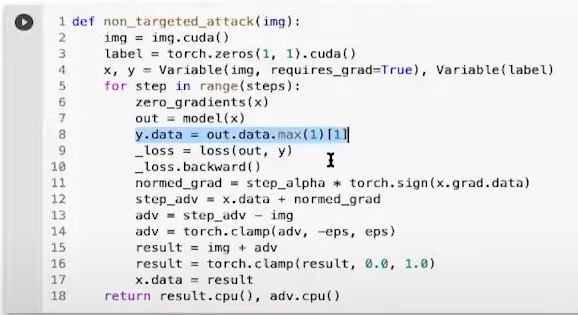

In [ ]:
пример adv атаки inception_v3 https://github.com/v-mk-s/adv-attacks-pytorch-101

In [ ]:
# мы не модель обучаем, а шум, с помощью градиентов изображения передающегося в модель model (черный ящик)
def non_targeted_attack(img):
  img = img.cuda() # перенос img
  label = torch.zeros(1,1).cuda() # тип атаки 0 - нетаргетированная, 1 - таргетированная
  x, y = Variables(img, requires_grad=True), Variables(label) # градиенты для изображения
  for step in range(steps):
    zero_gradients(x)
    out = model(x) # как в DeepDream градиенты изображения при прогонке через модельку тоже изменятся
    y.data = out.data.max(1)[1] # inception 
    _loss = loss(out, y) # loss либо SSIM либо D, выступающий в роли обучающей метрики метрики для шума
    _loss.backward() # одновременно происходит и обновление градиентов
    # шаг оптимизатора делать не нужно тк мы не обучать хотим, а обмануть модель
    normed_grad = step_alpha * torch.sign(x.grad.data) # нормируем градиент, шаг для градиента и в какую сторону шагать по знаку (шаг = const)
    step_adv = x.data + normed_grad # step_adv - шаг adversarial attack
    adv = step_adv - img # шум adversarial атаки
    adv = torch.clamp(adv, -eps, eps) # eps подбираем эмпирически
    result = img + adv # само изображение
    result = torch.clamp(result, 0.0, 1.0) # чтобы не было выбросов 
    x.data = result
  return result.cpu(), adv.cpu()

### Что дальше?

Довольно старый, но актуальный список трюков: https://github.com/soumith/ganhacks

Вообще, теория сходимости GANов очень сильно развилась за последнее время. Если хотите во всём этом разобраться, то возьмите какую-нибудь [достаточно новую статью](https://arxiv.org/pdf/1802.05957.pdf) и рекурсивно почитайте оттуда абстракты из списока литературы.

# Вывод:
Обучил DCGAN на лицах и применил Style Transfer в стиле Mone.

Дополнительно примененные техники улучшения стабильности гана:

1. Flip labels на каждой 100й эпохе для D
2. Техника из RL с возвратом на 1-4 эпохи назад с вероятностью 30%, отдельно для D и G 
3. AdamW для G и SGD для D.
4. Improved GANs, добавляю гауссовский шум на каждый слой G
5. Предобучил генератор
6. Tanh as the last layer of the generator output
7. Использую dropout в G в train и test состояниях
8. другие трюки, которые упоминались в занятии и частично реализованы в исходном ноутбуке

После генерации лиц применен Style Transfer: стиль Моне.